# [Starfish](http://www.ntnu.no/starfish)
A python application for the simulation and vizualization of 1d arterial networks. Capabilities include coupling with a wide variety of boundary conditions, usage of a number of material models for the arterial compliance, and stochastic simulation accounting for uncertainty in any model parameters.

## Demo
1. Example simulation of a 55 vessel arterial network
2. Analysis of calibration of the same network to noninvasive clinical imaging

## Outline of this tutorial

1. We will construct a simple 1 segment arterial network with a windkessel boundary condition
2. We will simulate this network and look at the pressure, flow and area of the vessel
3. We will vary geometrical and material parameters and plot the effects
4. We will uncertain parameters and evaluate the uncertainty and sensitivity of pressure, flow and area

## Basic results for waves in compliant tubes

Fluid flow in compliant tubes exhibits wave properties, thus it is of interest to note the fundamental relationship between the material parameters and the resulting wave speed

$$
c_{pw}^2 = \frac{A}{\rho C} 
$$
where $A$ is the cross sectional area and $C=\frac{\partial A}{\partial P}$ is called the compliance.

We will employ a Hookean type material model linearized about a reference pressure $P_s$
$$
A = (\frac{P-P_s}{\beta} + \sqrt{A_s})^2
$$
and
$$
\beta = \frac{4}{3} \sqrt{\pi} E h
$$
where $E$ is the elastic (Young's) modulus and $h$ is the thickness of the arterial wall.
From the function $A(P)$ we see that
$$
C = \frac{2}{\beta} (\frac{P-P_s}{\beta} + \sqrt{A_s})
$$

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

In [62]:
# In the real world
# 1. run singleVesselUQSA.xml with standard simulator?
# 2. run VascularPolynomialChaos.py  on the singleVesselUQSA.xml to produce vpcCase
# 3. run VascularPolynomialChaos.py on the resulting vpc.xml to evaluate all
import sys, os
import shutil
import numpy as np
import math
import starfish.UtilityLib.moduleFilePathHandler as mFPH
import starfish.UtilityLib.moduleXML as mXML
import starfish.NetworkLib.classVascularNetwork as cVN
import starfish.NetworkLib.classBoundaryConditions as cBC
import starfish.SolverLib.class1DflowSolver as c1dFS

In [64]:
mFPH.insertWorkingDirectory('~/starfish_wd') # Set directory for storing simulation results

In [58]:
# STARFISH works in (m-kg-s) system so all volumes should be in m^3 and all pressures in Pa.
# The following conversion factors may be useful
unit_mmhg_pa = 133.3
unit_pa_mmhg = unit_mmhg_pa**(-1)
unit_cm_m= 1. / 100.
unit_m_cm = unit_cm_m**(-1)
unit_m2_cm2 = unit_m_cm**2
unit_cm2_m2 = unit_cm_m**2

In [34]:
vascularNetwork = cVN.VascularNetwork()

In [35]:
vesselId = 1
vascularNetwork.addVessel(vesselId)
vessel = vascularNetwork.vessels[vesselId]

In [36]:
vessel.geometryType = 'cone'
vessel.length = 0.1
vessel.radiusDistal = (2.0/2*1e-2) # This is not used by uniform
vessel.radiusProximal =(2.5/2*1e-2)

In [37]:
vessel.complianceType = "Hayashi"
#vessel.constantCompliance = False
#vessel.externalPressure = 0.0
vessel.betaHayashi = 3.67 # Approximate value for a human aorta
vessel.As = None # Use Reference area 
vessel.Ps = 100*133.32# Reference Pressure at area As
vessel.N = 10

In [38]:
inlet = cBC.Sinus()
inlet.name = "Flow-Sinus2" # Necessary to set as an inflow boundary condition
inlet.amp = 50*1e-6
inlet.ampConst = 50*1e-6
inlet.freq = 1
inlet.Npulse =3

In [39]:
outlet = cBC.ReflectionCoefficient()
outlet.name = "_ReflectionCoefficient"
outlet.Rt  = 0.2

In [40]:
vascularNetwork.boundaryConditions[vessel.Id]=[inlet, outlet]

In [41]:
# Save network
networkName = "tutorial"
vascularNetwork.name = networkName
vascularNetwork.description=''
mXML.writeNetworkToXML(vascularNetwork)

In [61]:
# Run a specific instance of this network
dataNumber = "000"
vascularNetwork = mXML.loadNetworkFromXML(networkName, dataNumber='xxx') # dataNumber 'xxx' indicates the default network for the networkName
vascularNetwork.dataNumber = dataNumber
vascularNetwork.description=''
vascularNetwork.totalTime=10.0
vascularNetwork.initialsationMethod = "ConstantPressure"
vascularNetwork.initMeanPressure = 75*133.32
vascularNetwork.timeSaveEnd = vascularNetwork.totalTime
flowSolver = c1dFS.FlowSolver(vascularNetwork, quiet=True)
flowSolver.solve()
vascularNetwork.saveSolutionData()
mXML.writeNetworkToXML(vascularNetwork) # Save specific solution XML
del flowSolver #allow python to clean up solver memory

In [43]:
vascularNetwork.simulationTime[1:].shape
steps_per_sec = int(vascularNetwork.simulationTime[1:].shape[0]//vascularNetwork.totalTime)
steps_between = int(steps_per_sec//10)

<IPython.core.display.Javascript object>


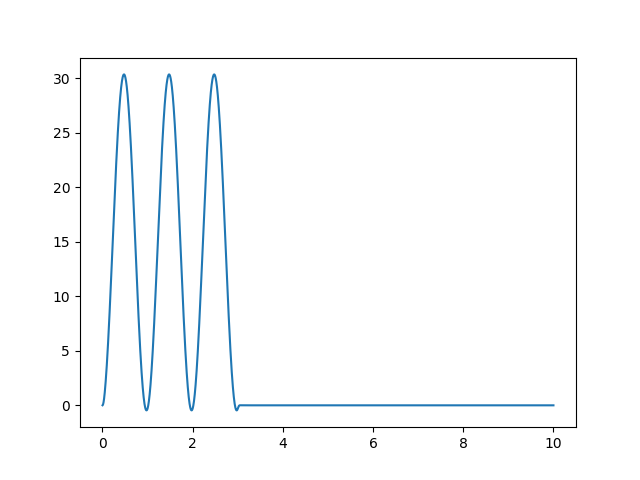

<IPython.core.display.Javascript object>


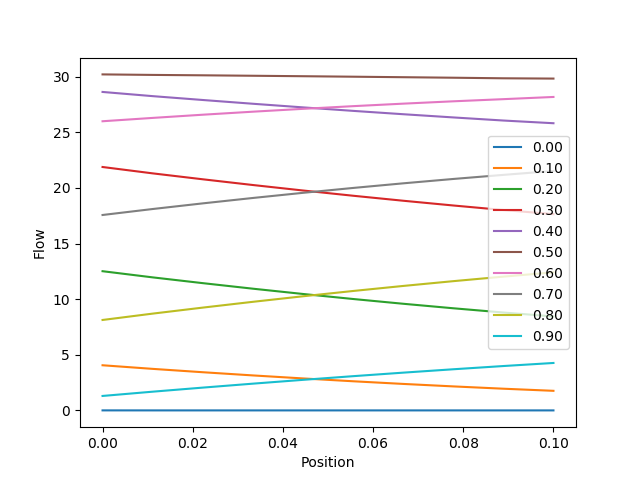

<IPython.core.display.Javascript object>


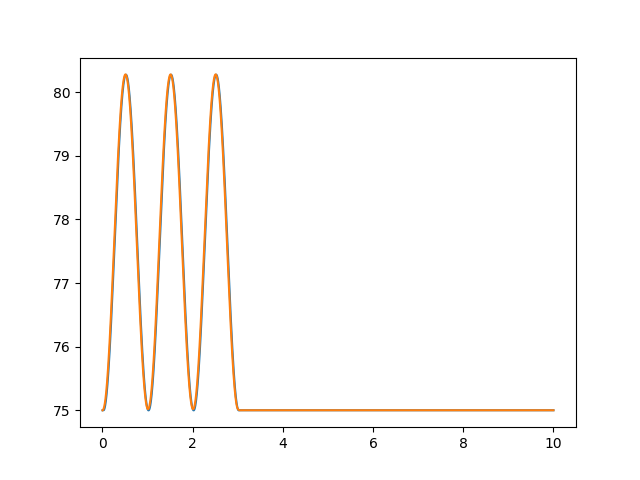

In [44]:
# Plot some results
vessel =vascularNetwork.vessels[1]

fig, Fax = plt.subplots(1,1)
Fax.plot(vascularNetwork.simulationTime[1:], vessel.Qsol[1:,0]*1e6)

fig, Fax_z = plt.subplots(1,1)
lines = Fax_z.plot(vessel.z, vessel.Qsol[1:steps_per_sec:steps_between,:].T*1e6)
#Fax_z.plot(vessel.z, vessel.Qsol[20,:]*1e6)
Fax_z.set_ylabel("Flow")
Fax_z.set_xlabel("Position")
Fax_z.legend(lines, ["{:.2f}".format(tval) for tval in vascularNetwork.simulationTime[1:steps_per_sec:steps_between]])
#plt.ylabel("Flow")

fig, Pax = plt.subplots(1,1)
Pax.plot(vascularNetwork.simulationTime[1:], vessel.Psol[1:,8]/133.32)
Pax.plot(vascularNetwork.simulationTime[1:], vessel.Psol[1:,0]/133.32)
#plt.ylabel("Pressure")

# [ST]ochastic [AR]terial blood [Flow] s[I]mulation[S] [h] 

The h is silent

In [45]:
import starfish.VascularPolynomialChaosLib.moduleFilePathHandlerVPC as mFPH_VPC
# Manages the file paths of the individual simulations and results withing the starfish working directory
import starfish.VascularPolynomialChaosLib.classUqsaCase as cUqsaCase
# Top level object configuring the UQSA it has the following subcomponents of importance
import starfish.VascularPolynomialChaosLib.classSampleManager as cSM
# Specifies and manages the sampling method to be used
import starfish.VascularPolynomialChaosLib.classRandomInputManager as cRIM
# Handles the random inputs and their dependence structure if specified
import starfish.VascularPolynomialChaosLib.classUqsaMethods as cUQM
# Manages the methods of UQSA to evaulate
import starfish.VascularPolynomialChaosLib.classLocationOfInterestManager as cLOIM 
# Tracks the various locations in the network where UQSA should be done

In [46]:
polychaos_method = cUQM.UqsaMethodPolynomialChaos()
polychaos_method.polynomialOrder = 3
polychaos_method.sampleFactor = 2

In [47]:
loi_manager = cLOIM.LocationOfInterestManager()
locationId = "vessel_1"
locationName = "root"
quantitiesOfInterestToProcess = ["Pressure", "Flow"]
xVal = 8*unit_cm_m
confidenceAlpha = 5
loi_manager.addLocationOfInterest(locationId, locationName,
                                  quantitiesOfInterestToProcess, xVal, confidenceAlpha)

In [48]:
rim = vascularNetwork.randomInputManager
rim = vascularNetwork.randomInputManager = cRIM.RandomInputManager()

In [49]:
uqsaCaseFile = mFPH_VPC.getFilePath('uqsaCaseXmlFile', networkName, dataNumber, 'write') # Creates path
uqsaCase = cUqsaCase.UqsaCase() 
if False and os.path.exists(uqsaCaseFile):
    uqsaCase.loadXMLFile(uqsaCaseFile)
    print(uqsaCase.uqsaMethods)
else:
    # 1. specify random variables
    rim = vascularNetwork.randomInputManager = cRIM.RandomInputManager()
    pct_unc = 0.05
    b = pct_unc*vessel.radiusProximal 
    a = vessel.radiusProximal - b/2
    rvType = "Uniform"
    parameter = "vessel_1_radiusProximal"
    rim.addRandomInput("Z1", a, b, rvType, parameter)

    pct_unc = 0.05
    b = pct_unc*vessel.betaHayashi 
    a = vessel.betaHayashi - b/2 # Center the RV on the baseline value
    rvType = "Uniform"
    parameter = "vessel_1_betaHayashi"
    rim.addRandomInput("Z2", a, b, rvType, parameter)

    sample_manager = uqsaCase.sampleManager = cSM.SampleManager()
    sample_manager.dependentCase = False
    sample_manager.samplingMethod = "S"

    # 2. specify quantities of interest
    uqsaCase.locationOfInterestManager = loi_manager = cLOIM.LocationOfInterestManager()
    locationId = "vessel_1"
    locationName = "root"
    quantitiesOfInterestToProcess = ["Pressure", "Flow"]
    xVal = 8*unit_cm_m
    confidenceAlpha = 5
    loi_manager.addLocationOfInterest(locationId, locationName,
                                      quantitiesOfInterestToProcess, xVal, confidenceAlpha)

    # 3. specify uqsa methods
    #     3.a gpc order, number of samples, sampling method

    polychaos_method = cUQM.UqsaMethodPolynomialChaos()
    polychaos_method.polynomialOrder = 3
    polychaos_method.sampleFactor = 2
    uqsaCase.uqsaMethods ={"PC-3":polychaos_method}

    # 4.
    uqsaCase.initialize(networkName,dataNumber)
    uqsaCase.simulateEvaluations = True
    uqsaCase.locationOfInterestManager.evaluateSimulationTime = True
    uqsaCase.multiprocessing = True
    # 5. save the configuration file to the starfish database
    configurationFilePath = mFPH_VPC.getFilePath('uqsaCaseXmlFile', networkName, dataNumber, 'write')
    uqsaCase.writeXMLFile(configurationFilePath)

In [50]:
import starfish.VascularPolynomialChaos as vpc
vpc.run_uqsa_case(uqsaCase, vascularNetwork=vascularNetwork)

## UQSA Results

In [51]:
loi = uqsaCase.locationOfInterestManager.locationsOfInterest['root']

In [52]:
qoi = loi.quantitiesOfInterest['Flow']

In [53]:
qoi.simulationTime

array([  0.00000000e+00,   1.94628409e-03,   3.89256817e-03, ...,
         9.99611506e+00,   9.99806135e+00,   1.00000076e+01])

In [54]:
t = uqsaCase.locationOfInterestManager.simulationTime

<IPython.core.display.Javascript object>


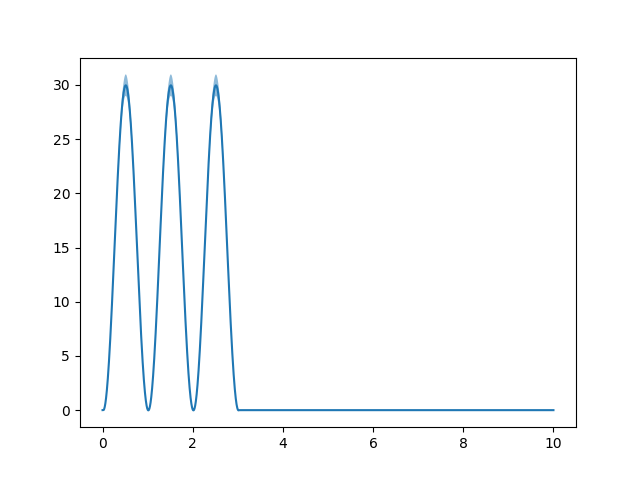

In [59]:
flow = loi.quantitiesOfInterest['Flow']
flow_uq = flow.uqsaMeasures['PC-3']
plt.figure()
plt.plot(flow.simulationTime,  unit_m_cm**(3)*flow_uq.expectedValue)
_ = plt.fill_between(flow.simulationTime, unit_m_cm**(3)*flow_uq.confidenceInterval[0],
                     unit_m_cm**(3)*flow_uq.confidenceInterval[1], alpha=.5)

<IPython.core.display.Javascript object>


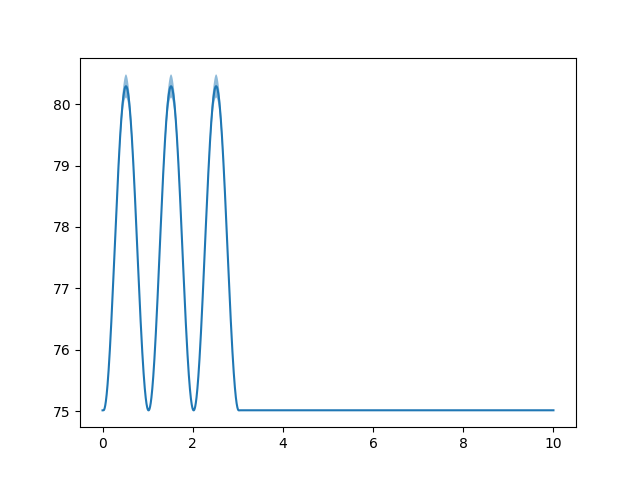

In [60]:
pressure = loi.quantitiesOfInterest['Pressure']
pressure_uq = pressure.uqsaMeasures['PC-3']
plt.figure()
plt.plot(pressure.simulationTime,  unit_pa_mmhg*pressure_uq.expectedValue)
_ = plt.fill_between(pressure.simulationTime, unit_pa_mmhg*pressure_uq.confidenceInterval[0],  unit_pa_mmhg*pressure_uq.confidenceInterval[1], alpha=.5)